In [ ]:
!nvidia-smi

Mon Jun 29 20:18:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!rm -rf data/
!rm -rf *.py
!rm -rf cats.zip
!wget https://raw.githubusercontent.com/NVIDIA/partialconv/master/models/partialconv2d.py
!wget https://raw.githubusercontent.com/MathiasGruber/PConv-Keras/master/libs/util.py
!wget https://gist.githubusercontent.com/alper111/8233cdb0414b4cb5853f2f730ab95a49/raw/c62a1aa4ee730a90017a0a3ec844857a9895c408/vgg_perceptual_loss.py

!wget https://git.darr.cloud/nicolas/cats-dataset/-/raw/master/cats.zip
!mkdir data
!unzip -o cats.zip

!mkdir samples

**UNet inspired model**

see https://github.com/milesial/Pytorch-UNet for reference


In [ ]:
# Parts of Autoencoder Model
import torch
import torch.nn as nn
import torch.nn.functional as F

class Sine(torch.nn.Module):
  def __init__(self, w0: float = 1.0, **kwargs):
    """
    Sine activation function with w0 scaling support.
    Args:
      w0: w0 in the activation step `act(x; w0) = sin(w0 * x)`
    """
    super(Sine, self).__init__(**kwargs)
    self.w0 = w0

  def forward(self, inputs, **kwargs):
    return torch.sin(self.w0 * inputs)

class LeakyTanh(torch.nn.Module):
  def __init__(self, leak_factor: float = 0.01, **kwargs):
    """
    Tanh activation function with LeakyReLU-like slope.
    Args:
      leak_factor: added slope of the function
    """
    super(LeakyTanh, self).__init__(**kwargs)
    self.leak_factor = leak_factor

  def forward(self, inputs, **kwargs):
    return torch.add(torch.tanh(inputs), torch.mul(inputs, self.leak_factor))

class DoubleConv(nn.Module):
  """(partialConvolution => [BN] => LeakyReLU) * 2"""

  def __init__(self, in_channels, out_channels, mid_channels=None):
    super().__init__()
    if not mid_channels:
      mid_channels = out_channels
    self.double_conv = nn.Sequential(
      PartialConv2d(in_channels, mid_channels, 3, multi_channel=True, padding = 1),
      #nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(mid_channels),
      #nn.LeakyReLU(inplace=True),
      LeakyTanh(),
      PartialConv2d(mid_channels, out_channels, 3, multi_channel=True, padding = 1),
      #nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(inplace=True)
      #LeakyTanh()
    )

  def forward(self, x):
    return self.double_conv(x)

class Down(nn.Module):
  """Downscaling with maxpool then double conv"""

  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
      nn.MaxPool2d(2),
      DoubleConv(in_channels, out_channels)
    )

  def forward(self, x):
    return self.maxpool_conv(x)

class Up(nn.Module):
  """Upscaling then double conv"""

  def __init__(self, in_channels, out_channels, bilinear=True):
    super().__init__()

    # if bilinear, use the normal convolutions to reduce the number of channels
    if bilinear:
      self.up = nn.Upsample(scale_factor=2, mode='nearest')
      self.conv = DoubleConv(in_channels, out_channels)
    else:
      self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
      self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    # input is CHW
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]

    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
            diffY // 2, diffY - diffY // 2])
    # if you have padding issues, see
    # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
    # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)

#  def forward(self, x1):
#    x1 = self.up(x1)
#    return self.conv(x1)

class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    #PartialConv2d(in_channels, out_channels, 1, multi_channel=True)

  def forward(self, x):
    return self.conv(x)

In [ ]:
# Model itself
from partialconv2d import PartialConv2d
from torch.nn import Sequential, ReLU, BatchNorm2d, ReflectionPad2d, Conv2d, ConvTranspose2d, MaxPool2d, MaxUnpool2d
import torch
from torchsummary import summary

class UNetInspired(torch.nn.Module):
  def __init__(self, bilinear=True):
    super(UNetInspired, self).__init__()
    
    layer1Depth = 64
    layer2Depth = layer1Depth*2
    layer3Depth = layer2Depth*2
    layer4Depth = layer3Depth*2

    self.inc = DoubleConv(4, layer1Depth)
    self.down1 = Down(layer1Depth, layer2Depth)
    self.down2 = Down(layer2Depth, layer3Depth)
    self.down3 = Down(layer3Depth, layer4Depth)
    self.up1 = Up(layer4Depth + layer3Depth, layer3Depth, bilinear=True)
    self.up2 = Up(layer3Depth + layer2Depth, layer2Depth, bilinear=True)
    self.up3 = Up(layer2Depth + layer1Depth, layer1Depth, bilinear=True)
    #self.up1 = Up(layer4Depth, layer3Depth, bilinear=True)
    #self.up2 = Up(layer3Depth, layer2Depth, bilinear=True)
    #self.up3 = Up(layer2Depth, layer1Depth, bilinear=True)
    self.outc = OutConv(layer1Depth, 3)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x = self.up1(x4, x3)
    x = self.up2(x, x2)
    x = self.up3(x, x1)
    #x = self.up1(x4)
    #x = self.up2(x)
    #x = self.up3(x)
    out = self.outc(x)
    return out

model = UNetInspired()

summary(model, (4, 256, 256), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     PartialConv2d-1         [-1, 64, 256, 256]           2,368
       BatchNorm2d-2         [-1, 64, 256, 256]             128
         LeakyTanh-3         [-1, 64, 256, 256]               0
     PartialConv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
         LeakyReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
     PartialConv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
        LeakyTanh-11        [-1, 128, 128, 128]               0
    PartialConv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
        LeakyReLU-14        [-1, 128, 1

In [ ]:
from util import MaskGenerator
from os import listdir
from PIL import Image
import torch
import numpy
import torchvision
import sys
import copy

class CatDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, transform=None):
        'Initialization'
        self.list_IDs = list_IDs 
        self.mask_generator = MaskGenerator(256, 256)
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def _damage_image(self, image, mask):
        damaged_image = copy.deepcopy(image)
        damaged_image[mask==0] = 0.
        return torch.cat((damaged_image, mask), 0)[:4][:][:]

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]        
        original_image = Image.open("cats/" + ID + ".jpg")

        # Scale down to 64, 64 

        original_image = torchvision.transforms.ToTensor()(original_image)
        
        mask = self.mask_generator.sample()
        
        mask = torch.Tensor(numpy.transpose(mask, (2, 0, 1)))
        damaged_image = self._damage_image(original_image, mask)

        if self.transform:
            original_image = self.transform(original_image)
            damaged_image = self.transform(damaged_image)
        return damaged_image, original_image


In [ ]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
%tensorboard --logdir=runs
tb = SummaryWriter()

In [ ]:
# add google drive to save model parameters
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.load_state_dict(torch.load("/content/drive/My Drive/DGM_Model/model_hybrid_3x3_1.16loss.pt"))

<All keys matched successfully>

In [ ]:
import numpy
import matplotlib.pyplot as plt
import torchvision
from vgg_perceptual_loss import VGGPerceptualLoss
from tqdm import tqdm
%matplotlib inline

use_cuda = True
use_loss_decay = False

start_epoch = 0
end_epoch = 20

torch.cuda.empty_cache()

# Example usage of Dataset

# Portion of data to use for validation
validation_split = 0.2

# Find all files in training data
files = [name[:-4] for name in listdir("cats")]

# Determine a split index accordingly to the validation set size
split = int(numpy.floor((1-validation_split) * len(files)))
# Split list of files at split index
train_files, val_files = files[:split], files[split:]

# Initialize the train and validation datasets
train_dataset = CatDataset(train_files)
val_dataset = CatDataset(val_files)


# Dataloader arguments
# Parameters
dataloader_params = {'batch_size': 14,
          'shuffle': False,
          'num_workers': 4}
train_dataloader = torch.utils.data.DataLoader(train_dataset, **dataloader_params)
val_dataloader = torch.utils.data.DataLoader(val_dataset, **dataloader_params)


device = torch.device("cuda:0" if use_cuda else "cpu")
model.to(device)
# Loop over epochs
#loss_fn = torch.nn.L1Loss()
#loss_fn = torch.nn.MSELoss()
loss_p = VGGPerceptualLoss()
loss_l1 = torch.nn.L1Loss()
loss_p.to(device)

min_epoch_loss = 10
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0000001, weight_decay=1e-8, momentum=0.9)
losses_sliding = []
for epoch in range(start_epoch, end_epoch):
    # Training
    progress = 0 
    epoch_losses = []

    pbar = tqdm(train_dataloader, ncols=200)
    for local_batch, local_labels in pbar:
        model.train()

        progress += 1
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        # Model computations
        recovered_image = model(local_batch)

        #loss = loss_fn(recovered_image, local_labels)
        loss = torch.add(loss_p(recovered_image, local_labels), loss_l1(recovered_image, local_labels))
        losses_sliding.append(loss.item())
        if len(losses_sliding) > 50:
            losses_sliding.pop(0)
        epoch_losses.append(loss.item())
        progress_perc = round(progress/(len(train_dataset)/dataloader_params["batch_size"])*100, 2)
        sliding_loss = sum(losses_sliding)/len(losses_sliding)
        
        pbar.set_description("Epoch {} ({:.1f}%):\tBL: {:.7f}\tSL: {:.7f}".format(epoch+1, progress_perc, loss, sliding_loss))
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        if(progress % 50 == 0):
            tb.add_scalar("Sliding loss/train", sliding_loss, progress)
            filename = "samples/sample"+ str(epoch).zfill(2) + "_" + str(progress).zfill(4) +".jpg"
            print("\nSaving jpeg: " + filename)
            torchvision.transforms.ToPILImage()(recovered_image[0].cpu()).save(filename, "JPEG")
            # save images to tensorboard
            images = recovered_image[:9]
            grid = torchvision.utils.make_grid(images, nrow=3)
            tb.add_image('images', grid, progress)

    epoch_loss = sum(epoch_losses)/len(epoch_losses)
    tb.add_scalar("Epoch loss/train", epoch_loss, epoch+1)

    # save current state if loss was reduced
    if (epoch_loss < min_epoch_loss):
      min_epoch_loss = epoch_loss
      torch.save(model.state_dict(), "/content/drive/My Drive/DGM_Model/model_hybrid_3x3_" + "{:.2f}".format(epoch_loss) + "loss.pt")

    #TODO: reduce lr if no improvement for 5 epochs
    if use_loss_decay and epoch % 2 == 0:
      lr = lr/2
      print("\nSetting learning rate to " + str(lr))
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("-"*20)
    print("Epoch Loss {}: {}".format(epoch + 1, epoch_loss))
    print("-"*20)
    #recovered_image = recovered_image * 255
    #print(local_batch[0])
    #print(recovered_image[0])
    #torchvision.transforms.ToPILImage()(recovered_image[0].cpu()).save("samples/sample"+ str(epoch) +".jpg", "JPEG")

In [ ]:
### remove all sample images from folder ###
!rm samples/*

In [ ]:
import numpy
import matplotlib.pyplot as plt
import torchvision
from vgg_perceptual_loss import VGGPerceptualLoss
%matplotlib inline


use_cuda = True

torch.cuda.empty_cache()

# Example usage of Dataset

# Portion of data to use for validation
validation_split = 0.2

# Find all files in training data
files = [name[:-4] for name in listdir("cats")]

# Determine a split index accordingly to the validation set size
split = int(numpy.floor((1-validation_split) * len(files)))
# Split list of files at split index
val_files = files[split:]

# Initialize the validation dataset
val_dataset = CatDataset(val_files)

# Dataloader arguments
# Parameters
dataloader_params = {'batch_size': 4,
          'shuffle': False,
          'num_workers': 6}
val_dataloader = torch.utils.data.DataLoader(val_dataset, **dataloader_params)


device = torch.device("cuda:0" if use_cuda else "cpu")
model.to(device)

# Loop over epochs
loss_p = VGGPerceptualLoss()
loss_l1 = torch.nn.L1Loss()
loss_p.to(device)

losses_sliding = []
for epoch in range(1):
    model.eval()

    # Validation
    progress = 0 
    epoch_losses = []
    for local_batch, local_labels in val_dataloader:
        progress += 1
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        # Model computations
        recovered_image = model(local_batch)

        loss = torch.add(loss_p(recovered_image, local_labels), loss_l1(recovered_image, local_labels))
        losses_sliding.append(loss.item())
        if len(losses_sliding) > 50:
            losses_sliding.pop(0)
        epoch_losses.append(loss.item())
        progress_perc = round(progress/(len(val_dataset)/dataloader_params["batch_size"])*100, 2)
        sliding_loss = sum(losses_sliding)/len(losses_sliding)
        
        print("{}%:\tLoss: {}\tSliding Loss: {}".format(progress_perc, loss, sliding_loss))


        if(progress % 50 == 0):
            filename = "samples/sample_val_" + str(progress).zfill(4) +".jpg"
            print("Saving jpeg: " + filename)
            torchvision.transforms.ToPILImage()(recovered_image[0].cpu()).save(filename, "JPEG")

    epoch_loss = sum(epoch_losses)/len(epoch_losses)

    print("-"*20)
    print("Validation Loss {}: {}".format(epoch + 1, epoch_loss))
    print("-"*20)

**Compare Ground Truth, Input and Output**

In [ ]:
validation_split = 0.2

files = [name[:-4] for name in listdir("cats")]

# Determine a split index accordingly to the validation set size
split = int(numpy.floor((1-validation_split) * len(files)))

files = files[split:]
dataset = CatDataset(files)
dataloader_params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 5}
dataloader = torch.utils.data.DataLoader(dataset, **dataloader_params)
dl_iter = iter(dataloader)

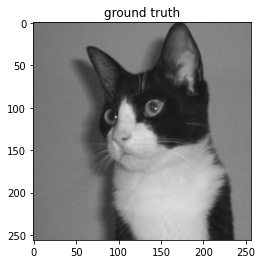

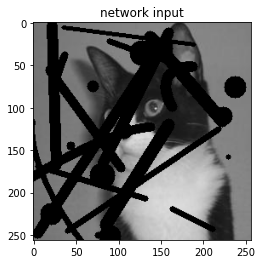

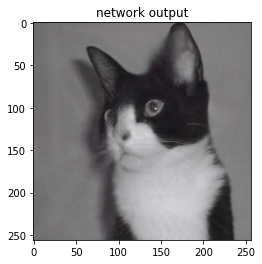

In [ ]:
import matplotlib.pyplot as plt
import torch

device = torch.device("cpu")
model.to(device)

sample = next(dl_iter)
input,_ = sample
input.to(device)

model.eval()
#best.eval()

gtData = sample[1][0]
plt.imshow(numpy.transpose(gtData, (1, 2, 0)))
plt.title("ground truth")
plt.show()

inputData = sample[0][0][0:3]
plt.imshow(numpy.transpose(inputData, (1, 2, 0)))
plt.title("network input")
plt.show()

outputData = model(input).detach().numpy()
plt.imshow(numpy.transpose(outputData[0], (1, 2, 0)))
plt.title("network output")
plt.show()

#outputData = best(input).detach().numpy()
#plt.imshow(numpy.transpose(outputData[0], (1, 2, 0)))
#plt.title("best output")
#plt.show()

In [ ]:
#torch.save(model.state_dict(), "/content/drive/My Drive/DGM_Model/" + "model.pt")

In [ ]:
testModel = torch.load("/content/drive/My Drive/DGM_Model/modelFinal.pt")
summary(testModel, (4, 256, 256), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     PartialConv2d-1         [-1, 64, 256, 256]           2,368
       BatchNorm2d-2         [-1, 64, 256, 256]             128
         LeakyTanh-3         [-1, 64, 256, 256]               0
     PartialConv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
         LeakyReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
     PartialConv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
        LeakyTanh-11        [-1, 128, 128, 128]               0
    PartialConv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
        LeakyReLU-14        [-1, 128, 1

In [ ]:
device = torch.device("cpu")
model.eval()
model.to(device)
torch.save(model, '/content/drive/My Drive/DGM_Model/modelFinal.pt')

**Convert model to Tensorflow**
(ONNX exported model not working properly!)

In [ ]:
import torch
import torchvision

dummy_input = torch.zeros(1, 4, 256, 256)
model.eval()
torch.onnx.export(model, 
                  dummy_input, 
                  "catNet.onnx", 
                  verbose=True, 
                  opset_version=11, 
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

In [ ]:
import onnx
from onnx_tf.backend import prepare

onnx_model = onnx.load("/content/catNet.onnx")  # load onnx model
pred = prepare(onnx_model).run(input)  # run the loaded model

In [ ]:
pip install git+https://github.com/onnx/tensorflow-onnx.git

  Cloning https://github.com/onnx/tensorflow-onnx.git to /tmp/pip-req-build-85drko0x
  Running command git clone -q https://github.com/onnx/tensorflow-onnx.git /tmp/pip-req-build-85drko0x
  Created wheel for tf2onnx: filename=tf2onnx-1.7.0-cp36-none-any.whl size=182809 sha256=c94422e3415537528f07b006c3918e53604f73bf17028dd8cd772a31d24a06aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-ohdpaqct/wheels/2b/0d/ea/ab39eaf1e77105a5727f3ff12e47d6ad01a2ec4fd34e00a8e9
Successfully built tf2onnx


In [ ]:
!onnx-tf convert -i /content/catNet.onnx -o /content/catNet.pb

/bin/bash: tf2onnx: command not found


In [ ]:
import onnx
from onnx_tf.backend import prepare
import tensorflow
onnxModel = onnx.load('/content/catNet.onnx')
tfModel = prepare(onnxModel)

In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format=tf_frozen_model --output_node_names='output' /content/catNet.pb /content/catNet-tfjs

2020-07-07 22:17:02.273077: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 16777216 exceeds 10% of free system memory.
2020-07-07 22:17:02.279366: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 16777216 exceeds 10% of free system memory.
2020-07-07 22:17:02.284156: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 16777216 exceeds 10% of free system memory.
2020-07-07 22:17:02.287503: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 16777216 exceeds 10% of free system memory.
2020-07-07 22:17:02.311019: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 16777216 exceeds 10% of free system memory.
2020-07-07 22:17:04.067699: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:797] Optimization results for grappler item: graph_to_optimize
2020-07-07 22:17:04.067749: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:799]   debug_stripper: debug_stripper did nothing. time = 0.254ms.
20

In [ ]:
!zip /content/catNetjs.zip /content/catNet-tfjs/*

	zip warning: name not matched: /content/catNet-tfjs/*

zip error: Nothing to do! (/content/catNetjs.zip)
